In [1]:
""" 
Import Libraries and create the preprocessing Function
"""
#Import libraries
import pytz
import numpy as np
import keras
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas_ta as ta
import MetaTrader5 as mt5
from datetime import datetime, timedelta, timezone
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
from keras.models import load_model
from timedelta import Timedelta
import os

#Use the Same Function to predict into the future
scaler = MinMaxScaler(feature_range=(0, 1))
def create_dataset(dataset, N=60):
    X, Y = [], []
    for i in range(len(dataset) - N):
        X.append(dataset[i:(i + N)])
        Y.append(dataset[i + N, -1])
    return np.array(X), np.array(Y)

# Apply the new function
N = 60
now = datetime.now(timezone.utc)

In [ ]:
"""  
You may need an active MetaTrader 5
Account for testing. You can open one in:
https://www.metatrader5.com/en
"""

if mt5.initialize():
    # Replace with your login credentials
    mt5.login(login="Login", server="Server", password="Your Password")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60, 256)           264192    
                                                                 
 dropout_16 (Dropout)        (None, 60, 256)           0         
                                                                 
 lstm_13 (LSTM)              (None, 60, 128)           197120    
                                                                 
 dropout_17 (Dropout)        (None, 60, 128)           0         
                                                                 
 lstm_14 (LSTM)              (None, 60, 64)            49408     
                                                                 
 dropout_18 (Dropout)        (None, 60, 64)            0         
                                                                 
 lstm_15 (LSTM)              (None, 60, 32)           

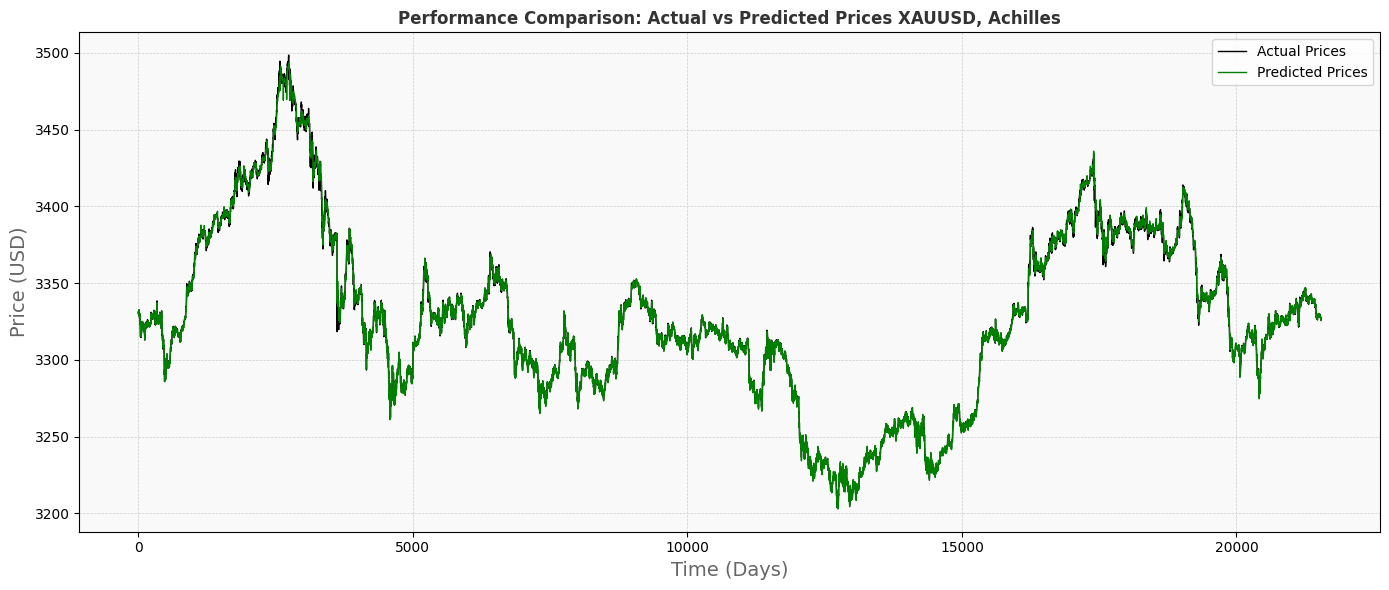

In [6]:
""" 
Test the model on previus Data and crate the Time
"""
import warnings
warnings.filterwarnings('ignore')
model = keras.models.load_model(r"C:\Users\Angel\OneDrive\Escritorio\Vs Code\Achilles\AchillesV1\ACHILLES V1.keras")
model.summary()
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

if mt5.initialize():
    # Replace with your login credentials
    mt5.login(login=51863590, server="ICMarketsSC-Demo", password="1lfz&CJ7jyX2N8")

# Get all symbols
all_symbols = mt5.symbols_get()

symbol = 'XAUUSD'


#TO CHECK THE BEST ACCURACY IN NASDAK SYMBOLS (OPTIONAL)
#nasdaq_symbols = [symbol for symbol in all_symbols if 'NAS' in symbol.name]
#sy = {}
# for symbol in nasdaq_symbols:
#     #CREATE A THE TEST DF
#     test = mt5.copy_rates_range(symbol.name, mt5.TIMEFRAME_M1, datetime(2024, 6, 1), now)
#     test = pd.DataFrame(test)
#     if test is None or len(test) == 0:
#         continue
    
#     test = pd.DataFrame(test)
#     if 'close' not in test.columns:
#         continue
    

#     test_1 = test['close'].tail(73368)
    
#     # Check if test_1 is empty
#     if test_1.empty:
#         continue
#     test_1 = test['close'].tail(73368)
#     test_scaled = scaler.fit_transform(np.array(test_1).reshape(-1, 1))
#     _, X_test = create_dataset(test_scaled, N)
#     _, y_test = create_dataset(test_scaled, N)
#     #RESHAPE FOR PREDICTIONS
#     elements_two = X_test.size
#     divisible_two = (elements_two // 60) * 60
#     X_predict_shape = X_test[:divisible_two]
#     X_test = X_predict_shape.reshape(-1, 60, 1)

#     elements_one = y_test.size
#     divisible_one = (elements_one // 60) * 60
#     y_predict_shape = y_test[:divisible_one]
#     y_test = y_predict_shape.reshape(-1, 60, 1)

#     y_pred = model.predict(X_test)
#     # Inverse scaling
#     y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
#     y_real = scaler.inverse_transform(y_test.reshape(-1, 1))
#     min_length = min(len(y_real), len(y_pred))
#     y_real = y_real[:min_length]
#     y_pred =y_pred[:min_length]
#     r = r2_score(y_true=y_real, y_pred=y_pred)
#     sy[symbol.name] = r

#Add time to match the timezones (ONlY FOR COLOMBIA)
time = timedelta(hours=5)

"""  
Here you may want to change start and end to predict the next week
To predict the next week you can add now or the last day.
The last day will be during how long you want your data to last for 
predictions. Then the data will be predicted based on past data
"""

start = datetime(2024, 8, 1) #CHANGE DINAMICALLY DEPENDING ON THE WEEK YOU WANT TO PREDICT
end = datetime(2025, 4, 1) #CHANGE DINAMICALLY DEPENDING ON THE WEEK YOU WANT TO PREDICT

now = datetime.now(timezone.utc) + time
test = mt5.copy_rates_range(symbol, mt5.TIMEFRAME_M1, start, now)
test = pd.DataFrame(test)
date = pd.to_datetime(test['time'], unit='s', utc=True)

test_1 = test['close'].tail(21600) #.tail(21600) to take only the last three weeks

test_scaled = scaler.fit_transform(np.array(test_1).reshape(-1, 1))

print("This needs to be near to 21600, (Three weeks to predict the next one)", len(test_scaled))

#Take the X_test and y_test and test columns for prediction
_, X_test = create_dataset(test_scaled, N)
_, y_test = create_dataset(test_scaled, N)


#RESHAPE FOR PREDICTIONS
elements_two = X_test.size
divisible_two = (elements_two // 60) * 60
X_predict_shape = X_test[:divisible_two]
X_test = X_predict_shape.reshape(-1, 60, 1)

elements_one = y_test.size
divisible_one = (elements_one // 60) * 60
y_predict_shape = y_test[:divisible_one]
y_test = y_predict_shape.reshape(-1, 60, 1)

#Prepare the test data
y_pred = model.predict(X_test)

# Inverse scaling
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_real = scaler.inverse_transform(y_test.reshape(-1, 1))


"""
DEFINE THE TIMEFRAME DF
"""

#TIME DF FOR NORMAL SYMBOLS (Forex and Commodities)
hours = timedelta(hours=7)
now = datetime.now() + hours
sixty_days = now + timedelta(days=7) #ADJUST THE DAYS
sixty_days = sixty_days.replace(microsecond=0)
date_range = pd.date_range(start=now.replace(microsecond=0), end=sixty_days, freq='1min')
date_range = date_range[date_range.dayofweek < 5]
time_df = pd.DataFrame(date_range)
time_df[0] = time_df[0].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
rows_time_df = len(time_df)
print(f"Needs to be 7200: {(rows_time_df)}")

#TIME DF FOR CRYPTO SYMBOLS
# now = datetime.now(timezone.utc) + timedelta(hours=2)

# sixty_days = now + timedelta(days=7)
# sixty_days = sixty_days.replace(microsecond=0)
# date_range = pd.date_range(start=date, end=sixty_days, freq='1min')
# time_df = pd.DataFrame(date_range)
# time_df[0] = time_df[0].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
# rows_time_df = len(time_df)
# print(f"Number of rows: {(rows_time_df)}")
# print(now)

#TIME DF FOR NASDAQ SYMBOLS
# now = datetime.now()
# end_time = now + timedelta(weeks=2)
# timestamps = []
# Loop through each day in the range
# current_time = now
# while current_time < end_time:
#     if current_time.weekday() < 5:  # Exclude Saturdays and Sundays
#         # Add minute-per-minute timestamps from 16:35 to 22:35
#         daily_start = current_time.replace(hour=16, minute=35, second=0, microsecond=0)
#         daily_end = current_time.replace(hour=22, minute=55, second=0, microsecond=0)
#         while daily_start <= daily_end:
#             timestamps.append(daily_start)
#             daily_start += timedelta(minutes=1)
#     current_time += timedelta(days=1)
# time_df = pd.DataFrame(timestamps, columns=["Timestamps"])
# rows_time_df = len(time_df)
# print(f"Number of rows: {(rows_time_df)}")

min_length = min(len(y_real), len(y_pred), len(date))
y_real = y_real[:min_length]
y_pred = y_pred[:min_length]
date = date[:min_length]
print(f"MAE Score {mean_absolute_error(y_true=y_real, y_pred=y_pred)}")
print(f"MAPE Score {mean_absolute_percentage_error(y_true=y_real, y_pred=y_pred)}")
print(f"R2 Score (Accuracy) {r2_score(y_true=y_real, y_pred=y_pred)}")


# Plot the results
plt.figure(figsize=(14, 6))
plt.plot(y_real, label='Actual Prices', color='black', linewidth=1.0)
plt.plot(y_pred, label='Predicted Prices', color='green', linewidth=1.0)
# Enhance axis aesthetics
plt.xlabel('Time (Days)', fontsize=14, color='#666666')
plt.ylabel('Price (USD)', fontsize=14, color='#666666')
plt.title(f'Performance Comparison: Actual vs Predicted Prices {symbol}, Achilles', fontweight='bold', color='#333333')
plt.grid(visible=True, linestyle='--', linewidth=0.5, color='#cccccc')
plt.legend()
plt.gca().set_facecolor('#f9f9f9')
plt.tight_layout()
plt.show()
plt.show()

In [7]:
"""
Define the range of dates you will predict, usually the Saturday of every week
For Commodities such as Gold, Silver and Cooper.
"""

today_date = datetime(year=2025, month=5, day=10) 
seven_next = datetime(year=2025, month=5, day=17)

time_range = pd.date_range(start=today_date, end=seven_next, freq='1min')
time_range = time_range[time_range.dayofweek < 5]
time_range = pd.DataFrame(time_range)
r = len(time_range)
print(time_range)

                       0
0    2025-05-12 00:00:00
1    2025-05-12 00:01:00
2    2025-05-12 00:02:00
3    2025-05-12 00:03:00
4    2025-05-12 00:04:00
...                  ...
7195 2025-05-16 23:55:00
7196 2025-05-16 23:56:00
7197 2025-05-16 23:57:00
7198 2025-05-16 23:58:00
7199 2025-05-16 23:59:00

[7200 rows x 1 columns]


In [8]:
"""  
Function to Predict the future
Arguments:
-batch_size = How many minutes we use at the same time to predict the next minute
-M = How many minutes we want to predict (7200 one week)
-R = How many minutes we use to predict the next M minutes
- timestamps = How many minutes we shift the data in the predited DataFrame
"""

def predict(batch_size, M, R, timestamps):
    
    window_data = X_test[-R:] 
    predictions = []

    for i in range(M):
        prediction = model.predict(window_data.reshape(-1, N, 1), batch_size= batch_size, verbose=0)  # Reshape for LSTM
        predictions.append(prediction[0, 0])  
        window_data = np.roll(window_data, - timestamps)  # Shift data by one time step
        window_data[-timestamps] = prediction[0, 0]  # Update last value with prediction
        if len(prediction) > M:
            break

    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

    return predictions

In [9]:
""" 
Make Predictions to the Future
"""

batch_size = 60 #OPTIMIZED
M = rows_time_df #OPTIMIZED
R = 21000 #OPTIMIZED
timestamps = 2 #OPTIMIZED

#to save the predictions
predictions = []

#Use the last R from X_test for predictions
window_data = X_test[-R:] 

predictions = predict(batch_size, M, R, timestamps)

predictions_df = pd.DataFrame(predictions, columns=['Predictions'])

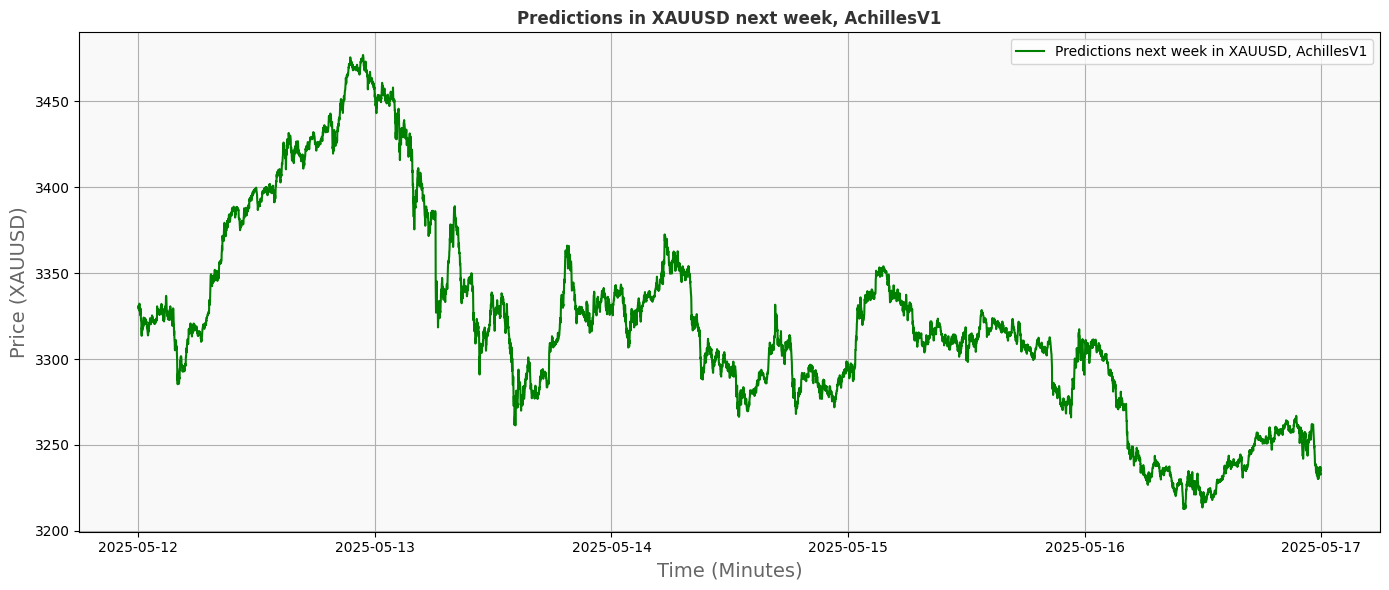

In [10]:
time_range.columns = ['Time']
predictions_df['Time'] = time_range['Time']
predictions_df['Time'] = pd.to_datetime(predictions_df['Time'])

#To show the real values   real = scaler.inverse_transform(np.array(window_data).reshape(-1, 1))
if np.isnan(predictions).sum() == 0:
    plt.figure(figsize=(14, 6))
    plt.plot(predictions_df['Time'], predictions, color='green', label=f'Predictions next week in {symbol}, AchillesV1')
    plt.title(f'Predictions in {symbol} next week, AchillesV1', fontweight='bold', color='#333333')
    plt.xlabel('Time (Minutes)', fontsize=14, color='#666666')
    plt.ylabel(f'Price ({symbol})', fontsize=14, color='#666666')
    plt.grid(True)
    plt.legend()
    plt.gca().set_facecolor('#f9f9f9')
    plt.tight_layout()
    plt.show()
else:
    print("Predictions contain NaN values.")

In [11]:
"""
Save the DataFrame
"""
#Save it to a df
stock_prices_df = pd.DataFrame(predictions)

#Match the sizes
min_length = min(len(time_df), len(stock_prices_df))
time_df = time_df[:min_length]
stock_prices_df = stock_prices_df[:min_length]

#Create a new full dataframe to be used in our trading bot.
full_df = pd.concat([time_df, stock_prices_df], axis='columns')
full_df = full_df.reset_index().drop_duplicates(subset='index', keep='last').set_index('index')
full_df.columns = ['Date', 'Price']
full_df['Price'] = full_df['Price'].astype(float).round(8)
 
#Save the dataframe
full_df.to_csv("Gold_Predictions.csv", index=False) 
print(full_df.duplicated)

<bound method DataFrame.duplicated of                       Date        Price
index                                  
0      2025-05-12 00:00:01  3329.895264
1      2025-05-12 00:01:01  3331.067139
2      2025-05-12 00:02:01  3329.506836
3      2025-05-12 00:03:01  3328.725830
4      2025-05-12 00:04:01  3329.895264
...                    ...          ...
7195   2025-05-16 23:55:01  3234.943359
7196   2025-05-16 23:56:01  3237.238525
7197   2025-05-16 23:57:01  3235.866943
7198   2025-05-16 23:58:01  3232.691895
7199   2025-05-16 23:59:01  3233.137207

[7200 rows x 2 columns]>


In [ ]:
"""
Optional to Compare the predicted DataFrame vs the Real DataFrame
"""

# if mt5.initialize():
#     # Replace with your login credentials
#     mt5.login(login="login", server="Server", password="Password")

# columns_names = ("Date", "Price")
# dataframe = pd.read_csv(r"C:\Users\Angel\OneDrive\Escritorio\Vs Code\Achilles\XAUUSD.csv", names=columns_names, skiprows=1)
# data = pd.DataFrame(dataframe)
# data["Date"] = pd.to_datetime(data["Date"], format='%Y-%m-%d %H:%M:%S')


# y = mt5.copy_rates_range(symbol, mt5.TIMEFRAME_M1, datetime(2024, 12, 23, 1), now)
# df_y = pd.DataFrame(y)
# df_y['time'] = pd.to_datetime(df_y["time"], unit='s')
# df_y = df_y['close']

# s_date = '2024-11-25 00:00:14'
# e_date = pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
# data_range = pd.date_range(start=s_date, end=e_date, freq='1min')
# rows = len(data_range)
# print(len(data_range))

# df_x = data.head(14401)
# df_x = df_x.loc[(df_x['Date'] >= s_date) & (df_x['Date'] <= e_date)]
# df_x = df_x['Price']
# min_length = min(len(df_y), len(df_x))
# df_y = df_y[:min_length]
# df_x = df_x[:min_length]
# print(len(df_x))
# print(len(df_y))


# # Create visualization
# plt.style.use('dark_background')
# plt.figure(figsize=(20, 10))
# #plt.plot(df_y, label='Prices', color='black')
# plt.plot(df_x, label='Predictions', color='#00ff00')
# plt.xlabel('Time')
# plt.ylabel('Price')
# plt.title('Actual vs. Predicted Prices')
# plt.grid(True)
# plt.legend()
# plt.show()

# plt.figure(figsize=(20, 10))
# plt.plot(df_y, label='Prices', color='#ff9900')
# #plt.plot(df_x, label='Predicted Prices', color='sienna')
# plt.xlabel('Time')
# plt.ylabel('Price')
# plt.title('Actual vs. Predicted Prices')
# plt.grid(True)
# plt.legend()
# plt.show()
# print(f"Mean Squeared Absolute Error: {np.sqrt(mean_absolute_error(y_true=df_y, y_pred=df_x))}")
# print(f"R2 Score: {r2_score(y_true=df_y, y_pred=df_x)}")